In [6]:
## ====================================
## EET-4501 – Applied Machine Learning
## Project Assignment 4
## ====================================

In [7]:
## Part 2: Dataset Loading & Basic Exploration

## We load the Robotic Operations Performance Dataset from the provided CSV file.
## This dataset contains operational metrics of industrial robotic systems, including processing time, accuracy, energy consumption, sensor readings, and defect detection indicators.

import pandas as pd
import numpy as np
import re

df = pd.read_csv("robot_dataset.csv")

print("Original Shape:", df.shape)
df.head()

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

print("Cleaned Column Names:")
print(df.columns)

def extract_numeric(value):
    if pd.isnull(value):
        return np.nan
    match = re.search(r"-?\d+\.?\d*", str(value))
    return float(match.group()) if match else np.nan

if "sensor_data" in df.columns:
    df["sensor_value"] = df["sensor_data"].apply(extract_numeric)
    df.drop(columns=["sensor_data"], inplace=True)
    print("Sensor data cleaned successfully.")
else:
    print("Warning: 'sensor_data' column not found.")

binary_columns = [
    "human_intervention_needed",
    "obstacle_detected",
    "defect_detected"
]

for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

id_columns = ["robot_id", "component_id"]

for col in id_columns:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Shape After Cleaning:", df.shape)
df.head()

Original Shape: (500, 12)
Cleaned Column Names:
Index(['robot_id', 'task_type', 'component_id', 'sensor_type', 'sensor_data',
       'processing_time_(s)', 'accuracy_(%)', 'environmental_status',
       'energy_consumption_(kwh)', 'human_intervention_needed',
       'obstacle_detected', 'defect_detected'],
      dtype='object')
Sensor data cleaned successfully.
Shape After Cleaning: (500, 10)


,task_type,sensor_type,processing_time_(s),accuracy_(%),environmental_status,energy_consumption_(kwh),human_intervention_needed,obstacle_detected,defect_detected,sensor_value
0,Inspection,LIDAR,67.0,90.4,Stable,2.2,0,1,1,1.0
1,Assembly,Thermal,71.2,98.1,Stable,2.7,1,0,0,85.3
2,Inspection,Thermal,49.2,95.3,Unstable,2.4,0,0,0,92.0
3,Welding,Camera,74.5,90.2,Stable,2.4,1,0,1,98.0
4,Assembly,Camera,64.5,97.2,Unstable,1.8,0,0,0,92.0


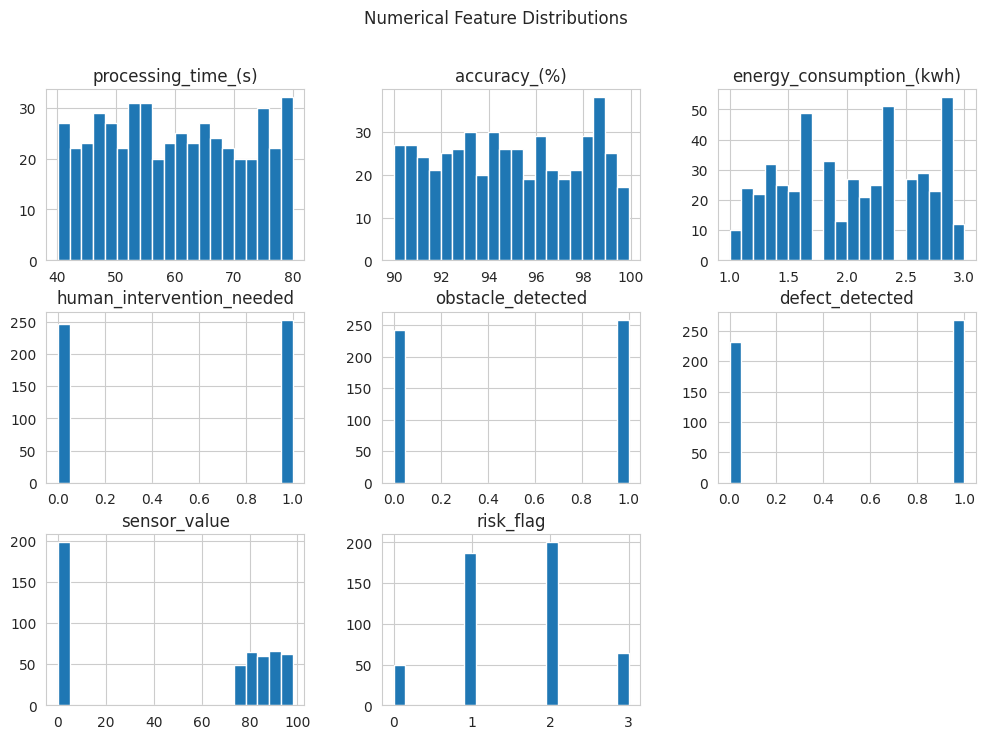

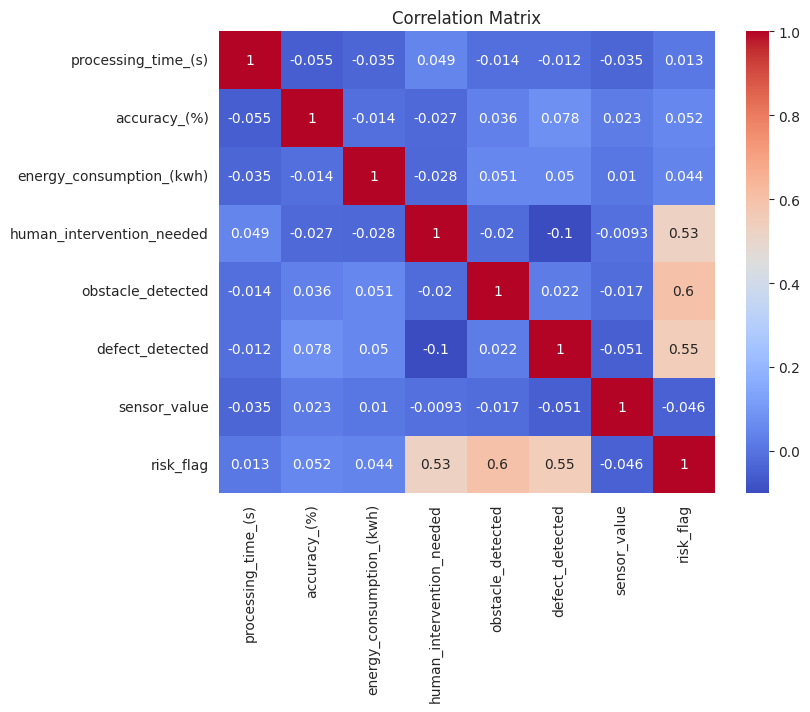

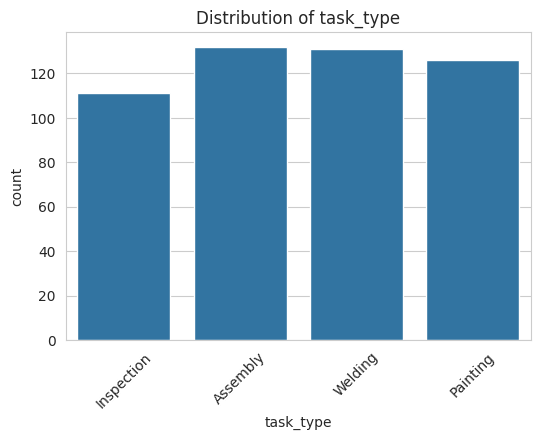

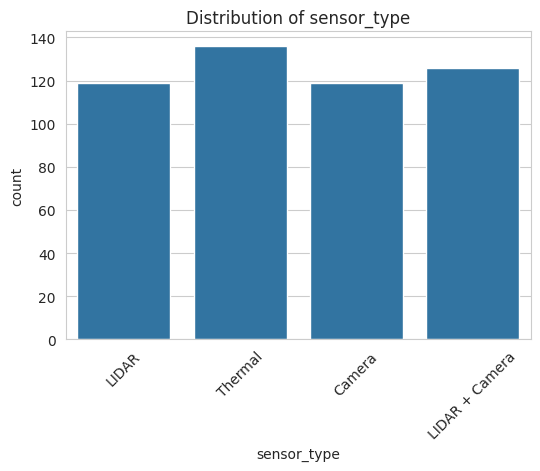

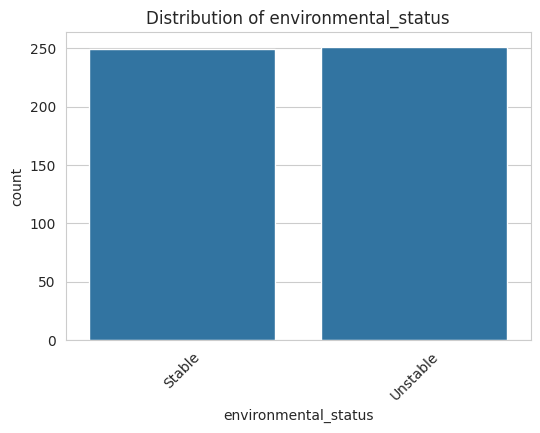

In [10]:
## Part 2.1: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# 1) Histogram
df[numeric_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Numerical Feature Distributions")
plt.show()

# 2) Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 3) Categorical Countplots
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.show()

In [9]:
## Part 3: Feature Typing & Preprocessing

## We categorize features into numerical and categorical types to build a structured preprocessing pipeline.

if "accuracy" in df.columns and "processing_time_(s)" in df.columns:
    df["efficiency_score"] = df["accuracy"] / df["processing_time_(s)"]

if "accuracy" in df.columns and "energy_consumption_(kwh)" in df.columns:
    df["energy_efficiency"] = df["accuracy"] / df["energy_consumption_(kwh)"]

risk_cols = [
    "human_intervention_needed",
    "obstacle_detected",
    "defect_detected"
]

existing_risk_cols = [col for col in risk_cols if col in df.columns]

if existing_risk_cols:
    df["risk_flag"] = df[existing_risk_cols].sum(axis=1)

# Numerical features
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Categorical features
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

print("Numerical Features:", numeric_features)
print("Categorical Features:", categorical_features)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

X_preprocessed = preprocessor.fit_transform(df)

print("Shape After Preprocessing:", X_preprocessed.shape)

feature_names = preprocessor.get_feature_names_out()

X_preview = pd.DataFrame(
    X_preprocessed[:5],
    columns=feature_names
)

X_preview

Numerical Features: ['processing_time_(s)', 'accuracy_(%)', 'energy_consumption_(kwh)', 'human_intervention_needed', 'obstacle_detected', 'defect_detected', 'sensor_value', 'risk_flag']
Categorical Features: ['task_type', 'sensor_type', 'environmental_status']
Shape After Preprocessing: (500, 18)


,num__processing_time_(s),num__accuracy_(%),num__energy_consumption_(kwh),num__human_intervention_needed,num__obstacle_detected,num__defect_detected,num__sensor_value,num__risk_flag,cat__task_type_Assembly,cat__task_type_Inspection,cat__task_type_Painting,cat__task_type_Welding,cat__sensor_type_Camera,cat__sensor_type_LIDAR,cat__sensor_type_LIDAR + Camera,cat__sensor_type_Thermal,cat__environmental_status_Stable,cat__environmental_status_Unstable
0,0.604858,-1.559878,0.319474,-1.012073,0.968496,0.930415,-1.209115,0.528807,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.964536,1.097084,1.178277,0.988071,-1.032529,-1.074789,0.757764,-0.667588,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.919491,0.130916,0.662995,-1.012073,-1.032529,-1.074789,0.914088,-1.863983,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.247140,-1.628890,0.662995,0.988071,-1.032529,0.930415,1.054079,0.528807,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.390764,0.786530,-0.367567,-1.012073,-1.032529,-1.074789,0.914088,-1.863983,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
